In [1]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import spotipy
import time
import random
import pandas as pd
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from spotipy import Spotify
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
# sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)


In [2]:
cid = 'e4215c596cbe4539bcaad095f3598e62'
secret = 'afb8ce320fde4ff89485958ad7e08122'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [11]:
playlist_id = '37i9dQZF1DXcBWIGoYBM5M'  # Spotify's "Today's Top Hits" playlist ID
results = sp.playlist_tracks(playlist_id, limit=100)
tracks = results['items']



In [5]:
track_ids = [track['track']['id'] for track in tracks]
audio_features = sp.audio_features(track_ids)

In [14]:
data = []
for track, features in zip(tracks, audio_features):
    if features is not None:
        track_info = sp.track(track['track']['id'])  # Retrieve track information
        data.append({
            'track_id': track['track']['id'],
            'track_name': track['track']['name'],
            'artist': track['track']['artists'][0]['name'],
            'popularity': track_info['popularity'],  # Add popularity variable
            'danceability': features['danceability'],
            'energy': features['energy'],
            'key': features['key'],
            'loudness': features['loudness'],
            'mode': features['mode'],
            'speechiness': features['speechiness'],
            'acousticness': features['acousticness'],
            'instrumentalness': features['instrumentalness'],
            'liveness': features['liveness'],
            'valence': features['valence'],
            'tempo': features['tempo']
        })

df = pd.DataFrame(data)
print(df)


                  track_id                                       track_name  \
0   6dOtVTDdiauQNBQEDOtlAB                               BIRDS OF A FEATHER   
1   2qSkIjg1o9h3YT9RAgYN75                                         Espresso   
2   4IadxL6BUymXlh8RCJJu7T                                        Too Sweet   
3   7221xIgOnuakPdLqT0F3nP            I Had Some Help (Feat. Morgan Wallen)   
4   2OzhQlSqBEmt7hmkYxfT6m                    Fortnight (feat. Post Malone)   
5   7fzHQizxTqy8wTXwlrgPQQ                              MILLION DOLLAR BABY   
6   629DixmZGHc7ILtEntuiWE                                            LUNCH   
7   46kspZSY3aKmwQe7O77fCC         we can't be friends (wait for your love)   
8   2FQrifJ1N335Ljm3TjTVVf                               A Bar Song (Tipsy)   
9   6tNQ70jh4OwmPGpYy6R2o9                                 Beautiful Things   
10  2HYFX63wP3otVIvopRS99Z                                          Houdini   
11  2GxrNKugF82CnoRFbQfzPf                       i l

In [39]:
X = df[["valence", "loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness"]]
X = X.dropna()
# X = sm.add_constant(X)
y = df['danceability']
model = sm.OLS(y, X)
trained = model.fit()
print(trained.summary())

df_test = pd.read_csv("tracks2018.csv")
y_test = df_test['danceability']
X_test = df_test[["valence", "loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness"]]
X_test = X_test.dropna()
predictions = trained.predict(X_test)

                                 OLS Regression Results                                
Dep. Variable:           danceability   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              218.9
Date:                Tue, 04 Jun 2024   Prob (F-statistic):                    1.75e-31
Time:                        14:01:06   Log-Likelihood:                          36.912
No. Observations:                  50   AIC:                                     -59.82
Df Residuals:                      43   BIC:                                     -46.44
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [50]:
df.to_csv('top_100_songs.csv', index = False)

50

In [42]:
y_test

0      0.571
1      0.610
2      0.458
3      0.458
4      0.329
       ...  
995    0.621
996    0.552
997    0.408
998    0.296
999    0.686
Name: danceability, Length: 1000, dtype: float64

In [43]:
predictions

0      0.532530
1      0.731416
2      0.907251
3      0.907251
4      0.721248
         ...   
995    0.769580
996    0.979180
997    0.450802
998    0.686006
999    0.755068
Length: 1000, dtype: float64

In [49]:
mse = mean_squared_error(y_test, predictions)
print("MSE on the test dataset:", (mse))

MSE on the test dataset: 0.23727129780641618


In [60]:
residuals = model.resid

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax)
ax.set_title('QQ Plot')
plt.show()

# Residual plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(model.predict(), residuals)
ax.axhline(y=0, color='red', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

# Scale-location plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(model.predict(), np.sqrt(np.abs(residuals)))
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Sqrt(|Residuals|)')
ax.set_title('Scale-Location Plot')
plt.show()

# leverage plot
leverage = model.get_influence().hat_matrix_diag
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(leverage, residuals)
ax.axhline(y=0, color='red', linestyle='-')
ax.set_xlabel('Leverage')
ax.set_ylabel('Residuals')
ax.set_title('Leverage Plot')
plt.show()



AttributeError: 'OLS' object has no attribute 'resid'

In [3]:
df_2016 = pd.read_csv("tracks2016.csv")
df_2017 = pd.read_csv("tracks2017.csv")
df_2018 = pd.read_csv("tracks2018.csv")
df_2019 = pd.read_csv("tracks2019.csv")
df_2020 = pd.read_csv("tracks2020.csv")
df_2021 = pd.read_csv("tracks2021.csv")
df_2022 = pd.read_csv("tracks2022.csv")

In [4]:
columns_to_remove = ['Unnamed: 0', 'album_cover_url', 'track_preview_url', 'track_uri']
for df in [df_2016, df_2017, df_2018, df_2019]:
    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
df_2016['year'] = 2016
df_2017['year'] = 2017
df_2018['year'] = 2018
df_2019['year'] = 2019
df_2020['year'] = 2020
df_2021['year'] = 2021
df_2022['year'] = 2022
stacked_df = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020, df_2022], ignore_index=True)

In [5]:
df = stacked_df

In [6]:
df.columns

Index(['artist_name', 'track_name', 'track_id', 'popularity', 'album_name',
       'album_id', 'album_release_date', 'album_type', 'track_duration_ms',
       'explicit', 'track_number', 'disc_number', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'artist_id',
       'artist_uri', 'artist_genres', 'artist_popularity', 'year'],
      dtype='object')

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np



df = stacked_df
X = df[["valence", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "mode", "year"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = sm.OLS(y_train, (X_train))
trained = model.fit()
print(trained.summary())

predictions = trained.predict((X_test))

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error (RMSE):", rmse)

                                 OLS Regression Results                                
Dep. Variable:           danceability   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              5055.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):                        0.00
Time:                        14:54:47   Log-Likelihood:                          1669.1
No. Observations:                4785   AIC:                                     -3318.
Df Residuals:                    4775   BIC:                                     -3254.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

df = stacked_df
X = df[["valence", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_with_constant)
trained = model.fit()
print(trained.summary())

predictions = trained.predict(X_test_with_constant)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Mean Squared Error (RMSE):", rmse)

                            OLS Regression Results                            
Dep. Variable:           danceability   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     443.6
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:55:44   Log-Likelihood:                 1657.0
No. Observations:                4785   AIC:                            -3296.
Df Residuals:                    4776   BIC:                            -3238.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4288      0.014  

In [37]:
results = model
residuals = results.resid

color = "#3199b4"

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax, color=color)
ax.set_title('QQ Plot')
fig.savefig('qq_plot.png')  # Save the plot as 'qq_plot.png'
plt.close(fig)  # Close the figure to free up memory

# Residual plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(results.predict(), residuals, color=color)
ax.axhline(y=0, color='red', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
fig.savefig('residual_plot.png')  # Save the plot as 'residual_plot.png'
plt.close(fig)

# Scale-location plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(results.predict(), np.sqrt(np.abs(residuals)), color=color)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Sqrt(|Residuals|)')
ax.set_title('Scale-Location Plot')
fig.savefig('scale_location_plot.png')  # Save the plot as 'scale_location_plot.png'
plt.close(fig)

# leverage plot
leverage = results.get_influence().hat_matrix_diag
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(leverage, residuals, color=color)
ax.axhline(y=0, color='red', linestyle='-')
ax.set_xlabel('Leverage')
ax.set_ylabel('Residuals')
ax.set_title('Leverage Plot')
fig.savefig('leverage_plot.png')  # Save the plot as 'leverage_plot.png'
plt.close(fig)

C:\Users\neoko\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

np.random.seed(2)

X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

param_grid = {
    'n_estimators': [5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 400, 500]
}

rf = RandomForestRegressor(random_state=2)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters: ", best_params)

predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("RMSE on test set: ", rmse)

Best hyperparameters:  {'n_estimators': 500}
RMSE on test set:  0.1189059185868779


n_estimators: 50, learning_rate: 0.01, RMSE: 0.17682610442370228
n_estimators: 50, learning_rate: 0.1, RMSE: 0.13099213568495383
n_estimators: 50, learning_rate: 0.5, RMSE: 0.1316242961462073
n_estimators: 50, learning_rate: 1.0, RMSE: 0.17289474011704292
n_estimators: 100, learning_rate: 0.01, RMSE: 0.15933320216338667
n_estimators: 100, learning_rate: 0.1, RMSE: 0.12716067440500115
n_estimators: 100, learning_rate: 0.5, RMSE: 0.13187441254846993
n_estimators: 100, learning_rate: 1.0, RMSE: 0.175867420124628
n_estimators: 200, learning_rate: 0.01, RMSE: 0.1434078302570399
n_estimators: 200, learning_rate: 0.1, RMSE: 0.12757993289011238
n_estimators: 200, learning_rate: 0.5, RMSE: 0.1362407802873306
n_estimators: 200, learning_rate: 1.0, RMSE: 0.1768736315965792
n_estimators: 300, learning_rate: 0.01, RMSE: 0.13648036394176777
n_estimators: 300, learning_rate: 0.1, RMSE: 0.1274392329913631
n_estimators: 300, learning_rate: 0.5, RMSE: 0.13703634502437098
n_estimators: 300, learning_rate

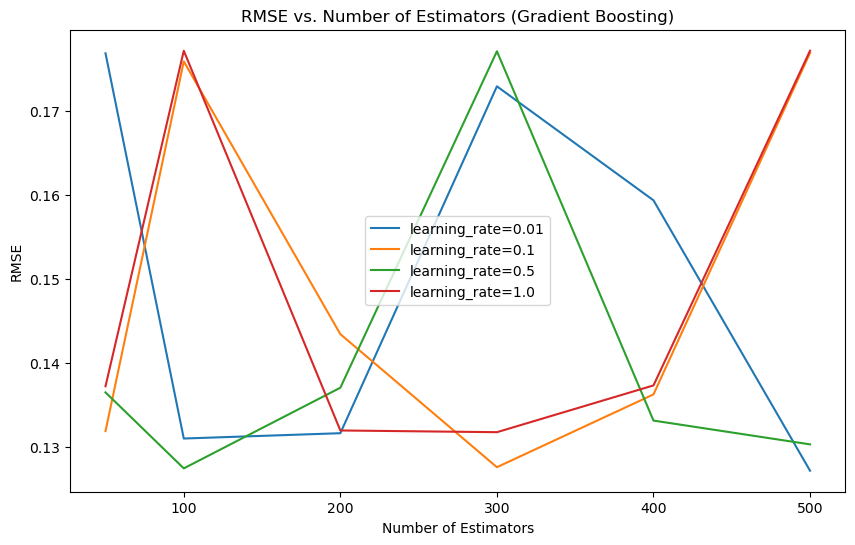

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

n_estimators_values = [50, 100, 200, 300, 400, 500]
learning_rate_values = [0.01, 0.1, 0.5, 1.0]
rmse_values = []

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=2)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)
        print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, RMSE: {rmse}")

plt.figure(figsize=(10, 6))
for i, learning_rate in enumerate(learning_rate_values):
    plt.plot(n_estimators_values, rmse_values[i*len(n_estimators_values):(i+1)*len(n_estimators_values)], label=f"learning_rate={learning_rate}")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Estimators (Gradient Boosting)")
plt.legend()
plt.show()

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

np.random.seed(2)

X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

model = ElasticNet(random_state=2)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters: ", best_params)

predictions = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("RMSE on test set: ", rmse)

Best hyperparameters:  {'alpha': 0.1, 'l1_ratio': 0.1}
RMSE on test set:  0.15291098288310584


Best parameters found:  {'C': 1, 'epsilon': 0.2, 'gamma': 0.1, 'kernel': 'rbf'}
Root Mean Squared Error:  0.13105830899551754


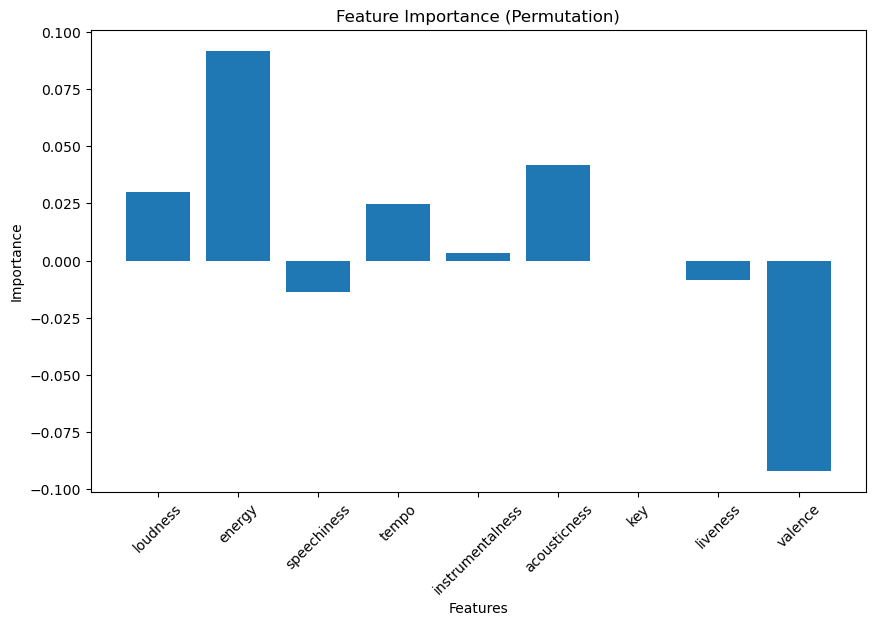

In [28]:
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)
print("Best parameters found: ", grid_search.best_params_)

best_svr = grid_search.best_estimator_
best_svr.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = best_svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Root Mean Squared Error: ", mse**0.5)

importance = permutation_importance(best_svr, X_test_scaled, y_test, scoring='neg_root_mean_squared_error')
feature_importance = importance.importances_mean

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Permutation)')
plt.xticks(rotation=45)
plt.show()

In [25]:
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['rbf']
}

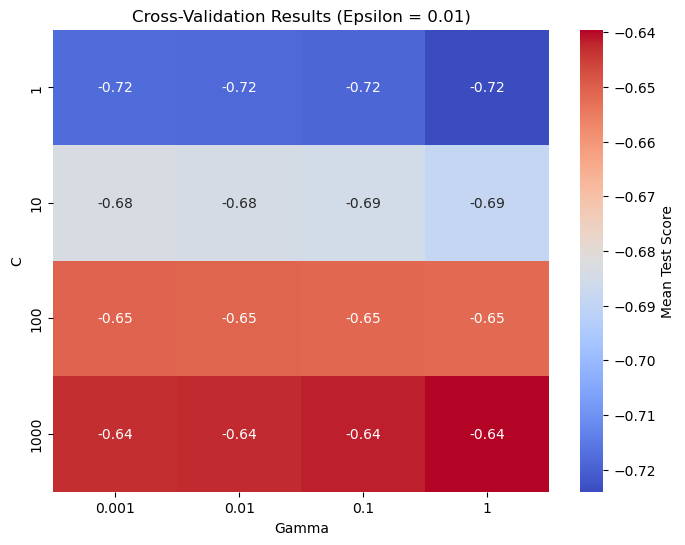

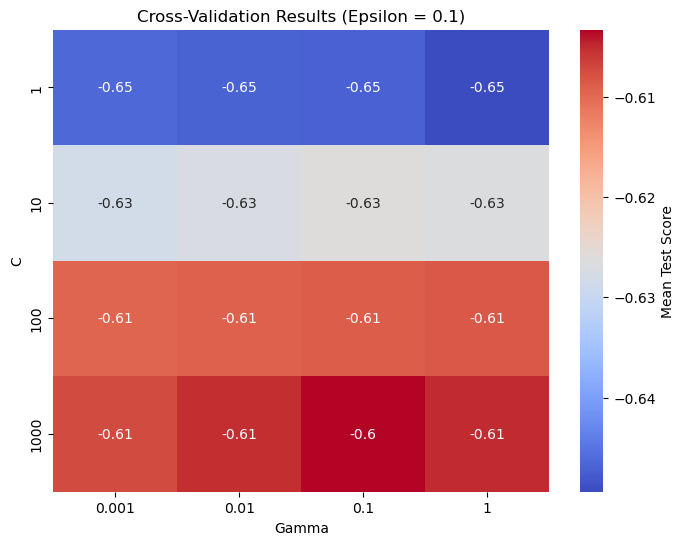

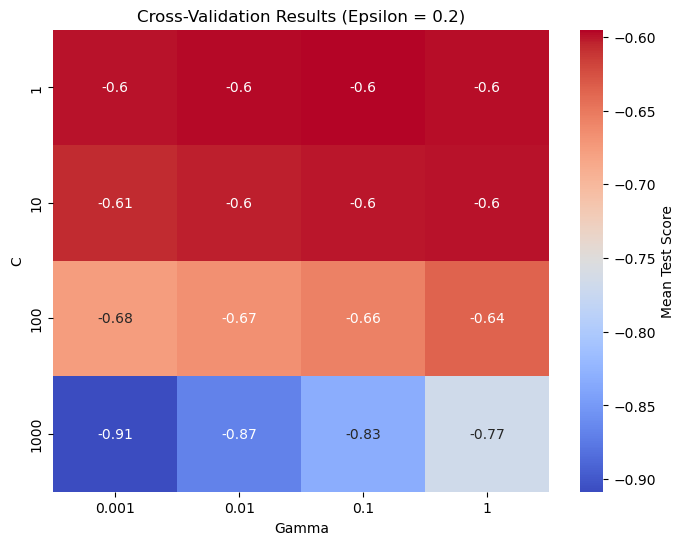

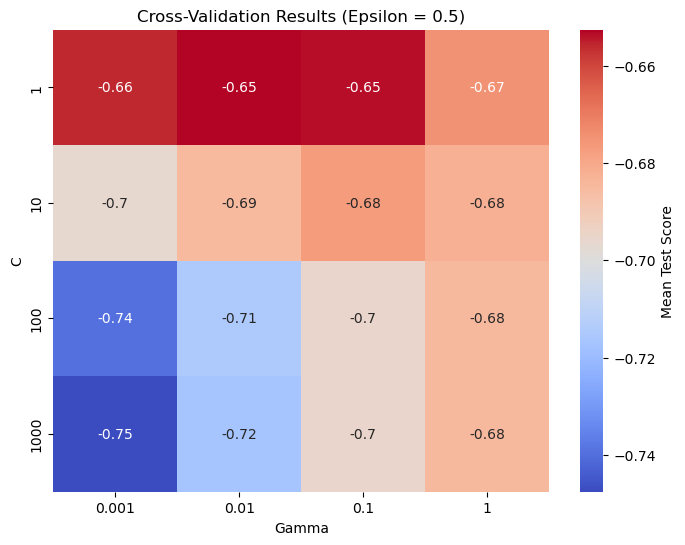

In [29]:
import seaborn as sns

cv_results = grid_search.cv_results_

mean_test_scores = cv_results['mean_test_score']

C_values = param_grid['C']
gamma_values = param_grid['gamma']
epsilon_values = param_grid['epsilon']

scores_matrix = mean_test_scores.reshape(len(C_values), len(gamma_values), len(epsilon_values))

for i, epsilon in enumerate(epsilon_values):
    plt.figure(figsize=(8, 6))
    sns.heatmap(scores_matrix[:, :, i], annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Test Score'}, 
                xticklabels=gamma_values, yticklabels=C_values)
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.title(f'Cross-Validation Results (Epsilon = {epsilon})')
    plt.show()

In [27]:
mean_test_scores

array([0.88693835, 0.88798328, 0.88777429, 0.88798328, 0.88589342,
       0.88798328, 0.88589342, 0.88798328, 0.88631139, 0.88798328,
       0.88652038, 0.88798328])

AttributeError: 'SVR' object has no attribute 'feature_importances_'

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[["loudness", "energy", "speechiness", "instrumentalness", "acousticness", "key", "mode", "liveness", "valence"]]
X_df = pd.DataFrame(X, columns=X.columns)

vif = pd.DataFrame()
vif["Feature"] = X_df.columns
vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(len(X_df.columns))]

print(vif)

            Feature       VIF
0          loudness  6.840041
1            energy  5.765900
2       speechiness  1.632311
3  instrumentalness  3.104679
4      acousticness  4.049964
5               key  2.918338
6              mode  2.509886
7          liveness  2.776929
8           valence  3.531737


In [26]:
X_df.columns

Index(['valence', 'energy', 'speechiness', 'tempo', 'instrumentalness',
       'acousticness', 'key', 'mode', 'liveness', 'valence'],
      dtype='object')

Best k value: 15
Best accuracy: 0.9084639498432601
Test accuracy: 0.9014202172096909


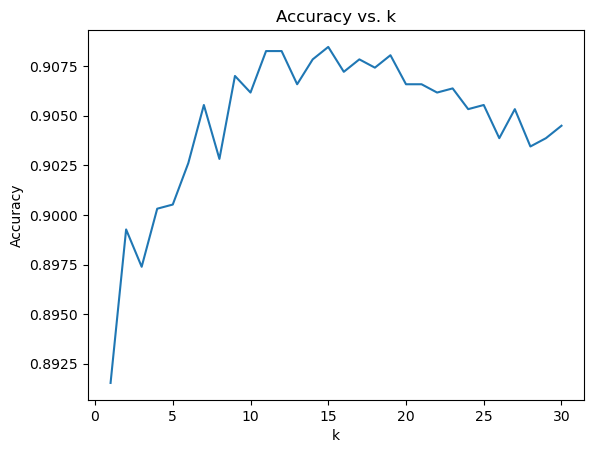

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df["explicit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_range = range(1, 31)

knn = KNeighborsClassifier()

param_grid = {"n_neighbors": k_range}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_["n_neighbors"]
best_accuracy = grid_search.best_score_

print("Best k value:", best_k)
print("Best accuracy:", best_accuracy)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

y_pred = best_knn.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

accuracies = grid_search.cv_results_["mean_test_score"]
plt.plot(k_range, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k")
plt.show()

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9264828738512949
Precision: 0.7837837837837838
Recall: 0.4461538461538462
F1-score: 0.5686274509803922


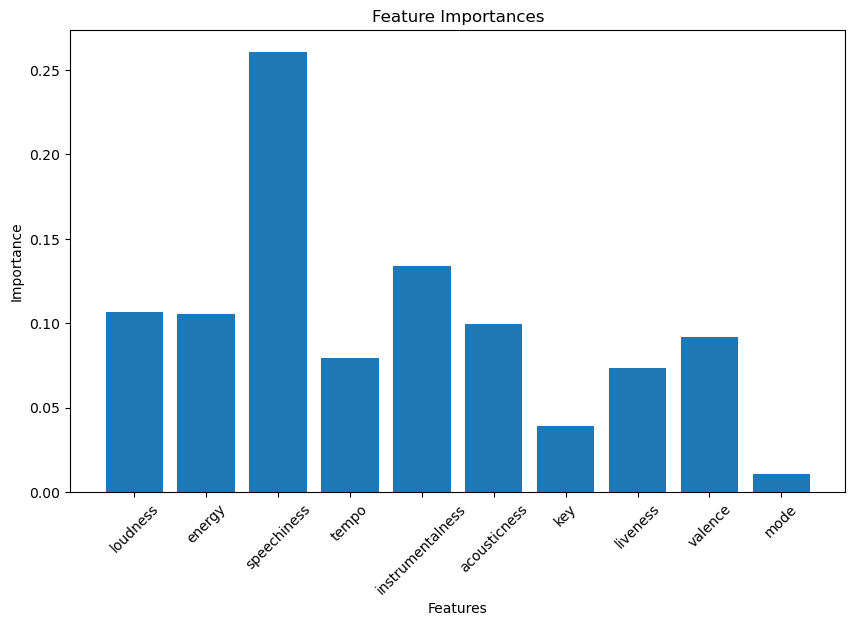

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


#df["mode"] = pd.Categorical(df["mode"])
X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df["explicit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

importances = best_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.show()

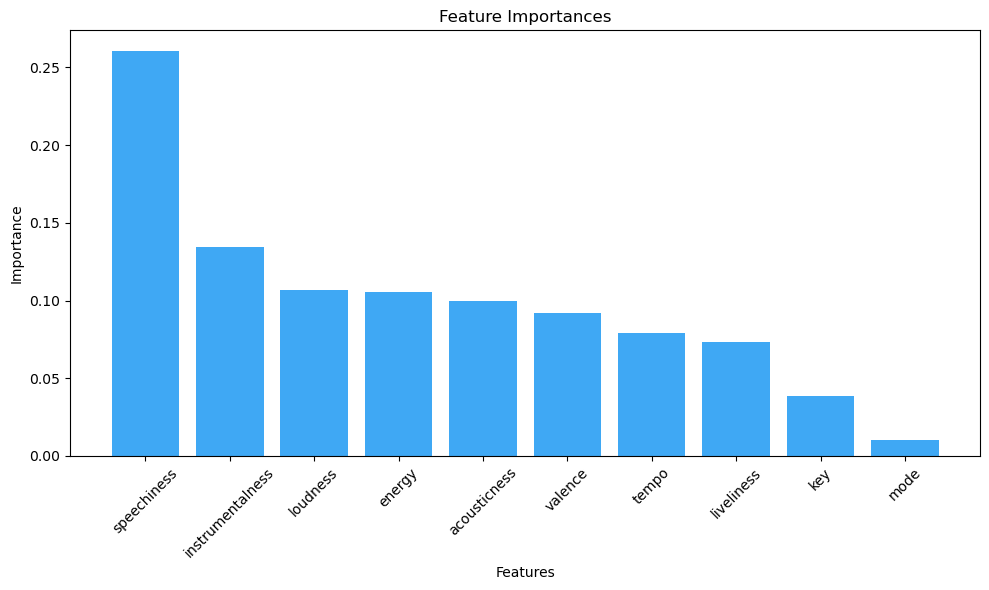

In [56]:
import matplotlib.pyplot as plt

feature_names = ["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveliness", "valence", "mode"]

sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

colors = ['#3fa8f4']

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, color=colors)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("feature_importances.png", dpi=300)

plt.show()

C:\Users\neoko\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8847117794486216
Precision: 0.1
Recall: 0.007692307692307693
F1-score: 0.014285714285714287


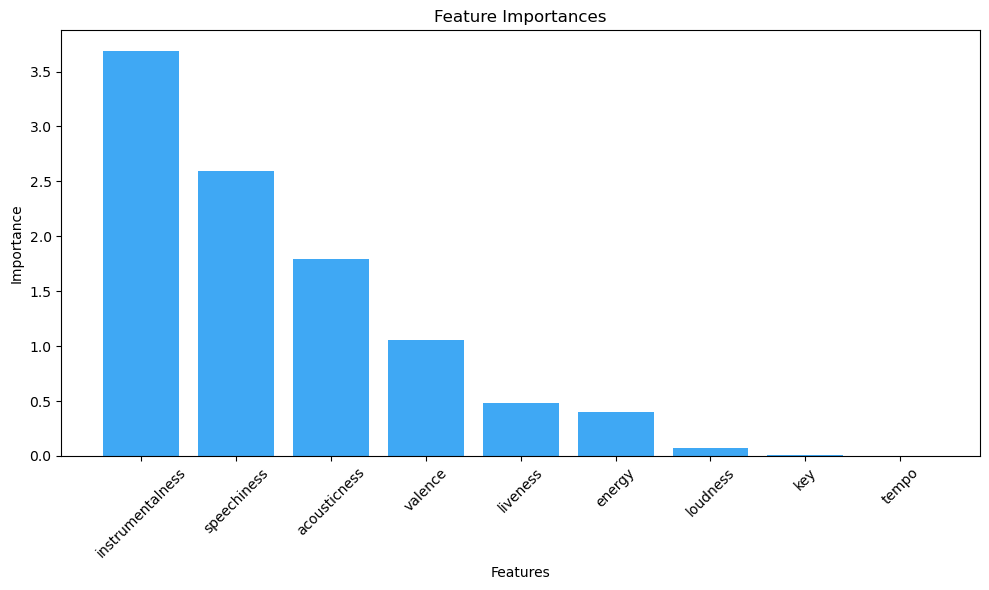

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(2)


X = df[["loudness", "energy", "speechiness", "tempo", "instrumentalness", "acousticness", "key", "liveness", "valence"]]
y = df["explicit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

lr = LogisticRegression(random_state=2)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

colors = ['#3fa8f4']

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, color=colors)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("feature_importances_LR.png", dpi=300)

plt.show()